In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [4]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,"film absolutely awful, but nevertheless, hilar...",0
1,well since seeing part 1 3 honestly say never ...,0
2,got see film preview dazzled it. not typical r...,1
3,adaptation positively butcher classic beloved ...,0
4,rzone awful movie! simple. seems tried make mo...,0


In [5]:
# Define training function with safe ADASYN handling
def train_logreg_tfidf_safe(X_train, X_test, y_train, y_test, imbalance_method='none', max_features=9000):
    ngram_range = (1, 3)  # Trigrams
    
    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    # Handle class imbalance
    try:
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)
    except ValueError as e:
        print(f"⚠️ {imbalance_method} skipped: {e}")
    
    # Logistic Regression + RandomizedSearchCV
    param_dist = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    }
    clf = LogisticRegression(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_dist, n_iter=5,
        scoring='f1_macro', n_jobs=-1, cv=cv, random_state=42, verbose=0
    )
    random_search.fit(X_train_vec, y_train)
    
    # Predictions & metrics
    y_pred = random_search.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({imbalance_method})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Save model & vectorizer
    model_filename = f'logreg_tfidf_{imbalance_method}.pkl'
    vectorizer_filename = f'vectorizer_tfidf_{imbalance_method}.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(random_search.best_estimator_, f)
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(vectorizer, f)
    
    print(f"✅ Model & Vectorizer saved for imbalance_method={imbalance_method}")
    
    return {
        'imbalance_method': imbalance_method,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'best_params': random_search.best_params_
    }

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category']
)


Running experiment with imbalance_method=none


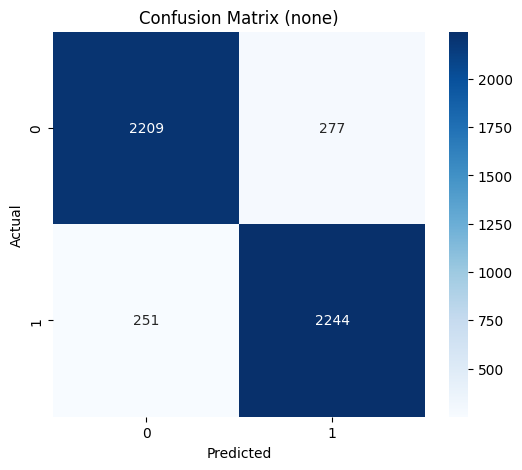

✅ Model & Vectorizer saved for imbalance_method=none

Running experiment with imbalance_method=oversampling


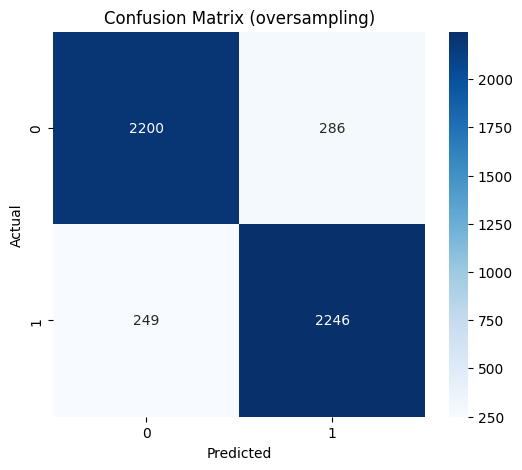

✅ Model & Vectorizer saved for imbalance_method=oversampling

Running experiment with imbalance_method=adasyn
⚠️ adasyn skipped: No samples will be generated with the provided ratio settings.


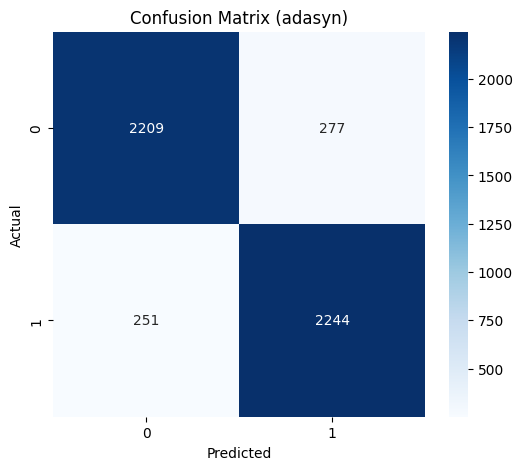

✅ Model & Vectorizer saved for imbalance_method=adasyn

Running experiment with imbalance_method=undersampling


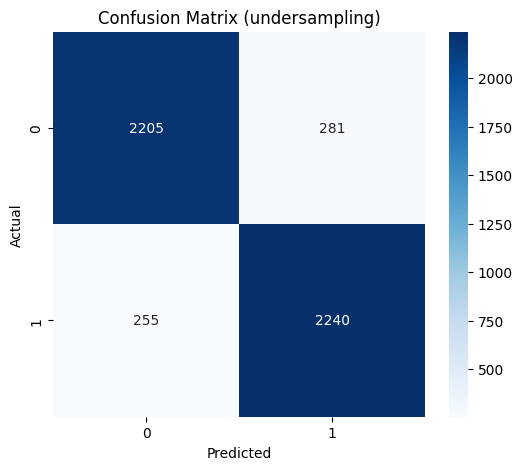

✅ Model & Vectorizer saved for imbalance_method=undersampling

Running experiment with imbalance_method=smote_enn


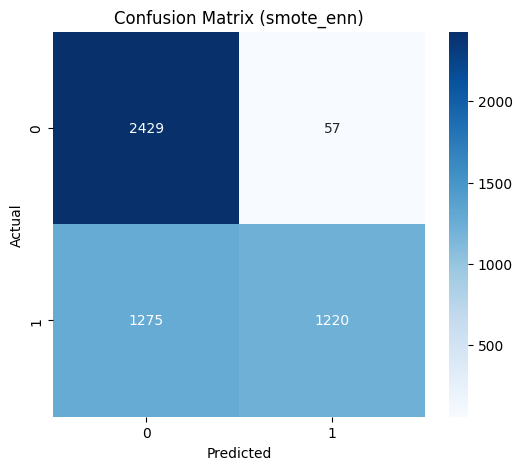

✅ Model & Vectorizer saved for imbalance_method=smote_enn


In [7]:
# Run experiments
imbalance_methods = ['none', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']
results = []

for method in imbalance_methods:
    print(f"\nRunning experiment with imbalance_method={method}")
    result = train_logreg_tfidf_safe(X_train, X_test, y_train, y_test, imbalance_method=method)
    results.append(result)

In [8]:
results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_result = results_df.loc[best_idx]
print("\n🏆 Best Result:")
print(best_result)


🏆 Best Result:
imbalance_method                                             none
accuracy                                                 0.893997
precision                                                0.894045
recall                                                   0.893987
f1                                                       0.893992
best_params         {'solver': 'lbfgs', 'max_iter': 300, 'C': 10}
Name: 0, dtype: object


In [9]:
# Load best model & vectorizer
best_imbalance_method = best_result['imbalance_method']

model_filename = f'logreg_tfidf_{best_imbalance_method}.pkl'
vectorizer_filename = f'vectorizer_tfidf_{best_imbalance_method}.pkl'

with open(model_filename, 'rb') as f:
    best_model = pickle.load(f)
with open(vectorizer_filename, 'rb') as f:
    best_vectorizer = pickle.load(f)

print(f"✅ Loaded best model & vectorizer for imbalance_method={best_imbalance_method}")

✅ Loaded best model & vectorizer for imbalance_method=none


In [10]:
# Make predictions on test set
X_test_vec = best_vectorizer.transform(X_test)
y_pred = best_model.predict(X_test_vec)

In [11]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n📊 Best Model Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


📊 Best Model Metrics:
Accuracy: 0.8940
Precision: 0.8940
Recall: 0.8940
F1-score: 0.8940


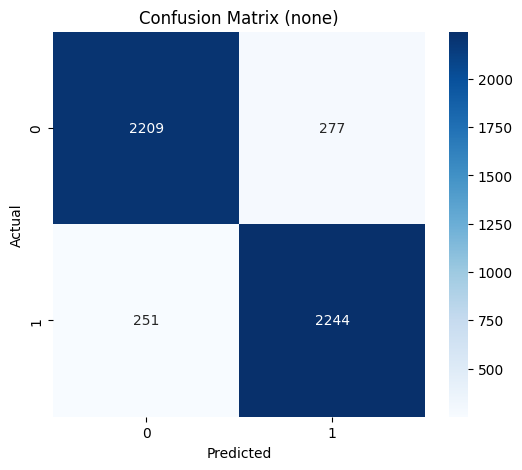

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best_imbalance_method})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Predict on new data
new_text = ["This movie was amazing and exciting!"]
new_vec = best_vectorizer.transform(new_text)
prediction = best_model.predict(new_vec)
print(f"Predicted category for new text: {prediction[0]}")

Predicted category for new text: 1


In [15]:
# Save model & vectorizer as .pkl
import pickle
# Save model
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save vectorizer
with open('vectorizer_model.pkl', 'wb') as f:
    pickle.dump(best_vectorizer, f)

print("✅ Model and vectorizer saved successfully!")

✅ Model and vectorizer saved successfully!
